### Augmentation Script

The purpose of this script is to demonstrate how the augmentation logic in the Wayne_RPE dataset work.

In [95]:
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
import tifffile as tiff
import cv2

from icecream import ic
from random import randint
from scipy import ndimage
from torchvision import transforms

from src.datasets import _find_center_mask, _get_min_max_axis, _normalize_image
from src.helpers import _determine_slurm

We can start by loading a sample image as a tiff file:

Text(0.5, 1.0, 'Cell 0001, Z=10 (DNA1)')

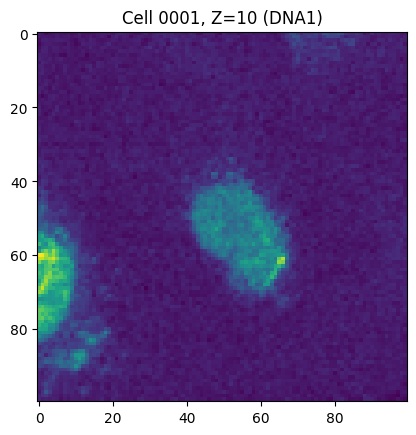

In [96]:
FILEPATH = "/nas/longleaf/home/oem/PHASER/data/phaser_rpe/raw/images/cell_0002.tif" if _determine_slurm() else "/home/omar/projects/unc/PHASER/data/phaser_rpe/raw/images/cell_0002.tif" 
image = tiff.imread(FILEPATH)
image = torch.tensor(image)
image = _normalize_image(image)

plt.imshow(image[10])
plt.title("Cell 0001, Z=10 (DNA1)")

Next, we need to find the middle-most masks in this image and create new binary masks withy only the center-most masks. We append these masks to the tensor along with a combined version of the original nuc and ring masks, as well as the centered ones.

Original shape: torch.Size([59, 100, 100])
New shape: torch.Size([63, 100, 100])


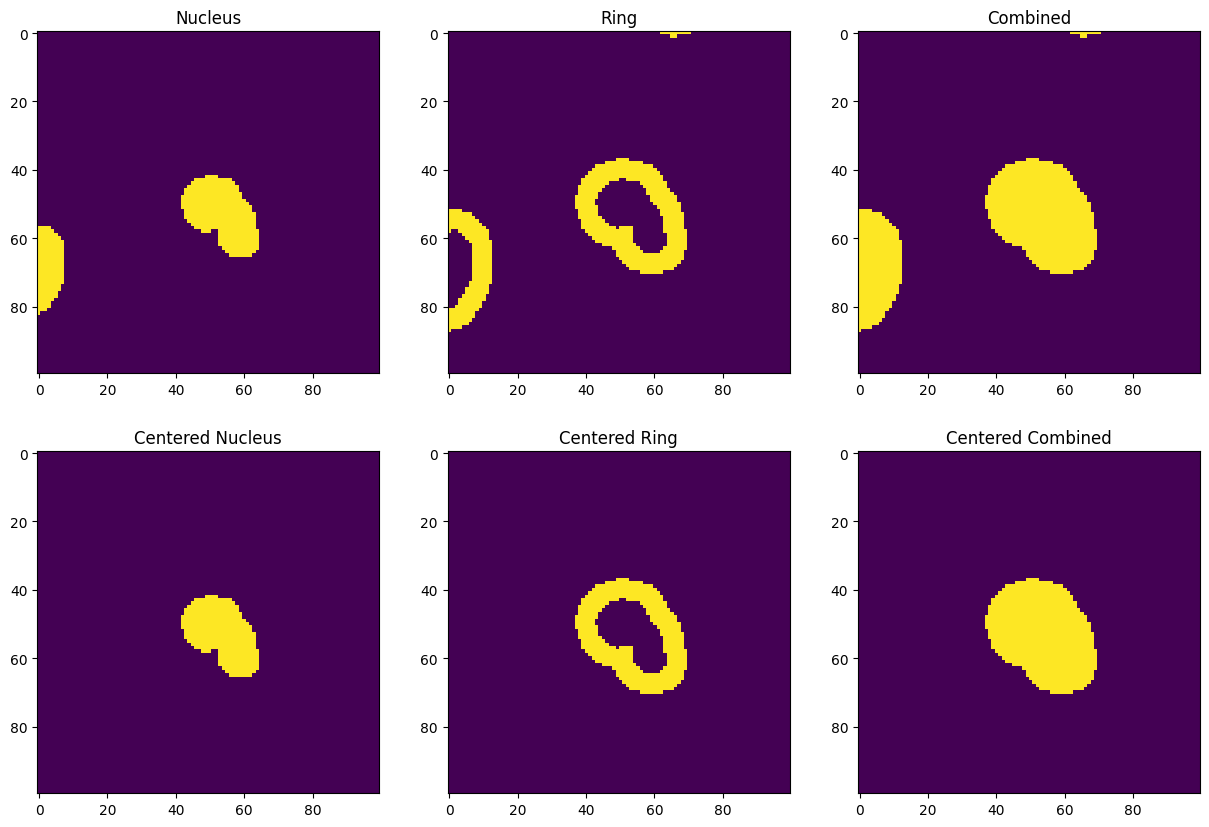

In [97]:
print('Original shape:', image.shape)

# masks
nuc = image[57].bool()
ring = image[58].bool()
combined = torch.logical_or(nuc, ring)

orig_masks = [nuc, ring, combined]

centered_masks = [_find_center_mask(mask) for mask in orig_masks]
all_masks = orig_masks + centered_masks
titles = ["Nucleus", "Ring", "Combined", "Centered Nucleus", "Centered Ring", "Centered Combined"]
    
# now add these to the tensor
masks_to_add = tuple(mask.unsqueeze(0) for mask in all_masks[2:])
image = torch.cat((image, *masks_to_add), dim=0)

print('New shape:', image.shape)

# plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, mask in enumerate(all_masks):
    ax = axs[i // 3, i % 3]
    ax.imshow(mask)
    ax.set_title(titles[i])

Now, if augmentations are enabled, we augment by rotating and shifting. We rotate first:

Text(0.5, 1.0, 'Rotated Image, Z=10 (DNA1), Angle=8')

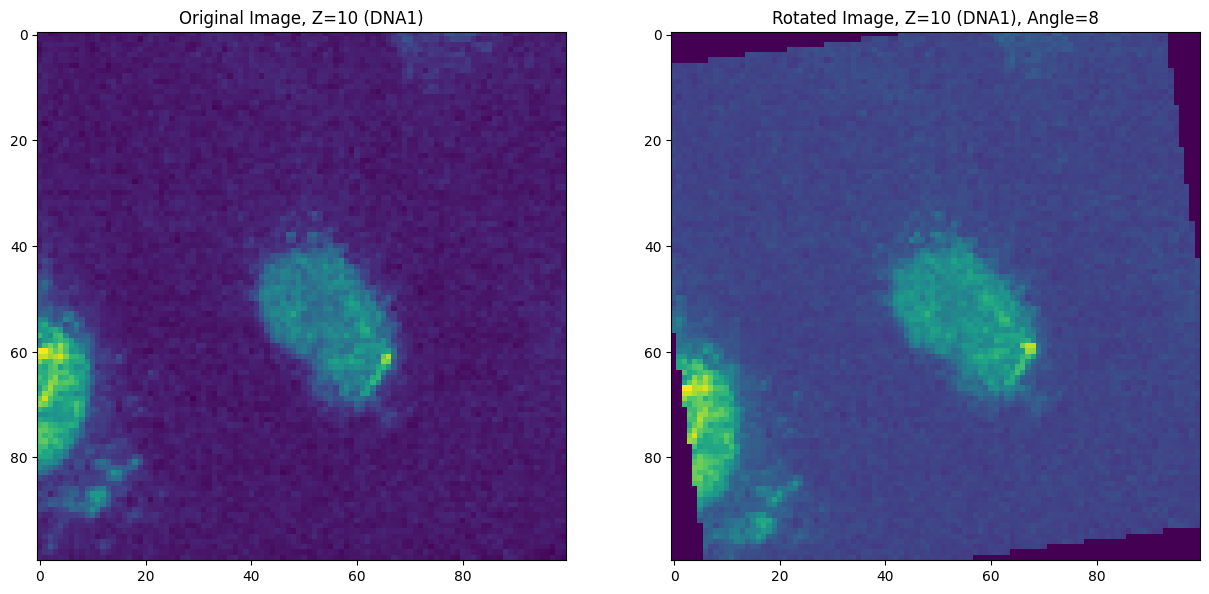

In [98]:
# copy image
image_copy = image.clone()
assert torch.equal(image, image_copy)

# Get a random angle to rotate to
angle = np.random.randint(0, 360)
image_copy = transforms.functional.rotate(image_copy, angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image[10])
axs[0].set_title("Original Image, Z=10 (DNA1)")
axs[1].imshow(image_copy[10])
axs[1].set_title(f"Rotated Image, Z=10 (DNA1), Angle={angle}")

Now, we can translate the image. We can use the combined mask (or the ring mask) to define the maximum shifts we can make without cutting off the cell nucleus. To do this we use the `_get_min_max_axis()` function from `datasets.py`:

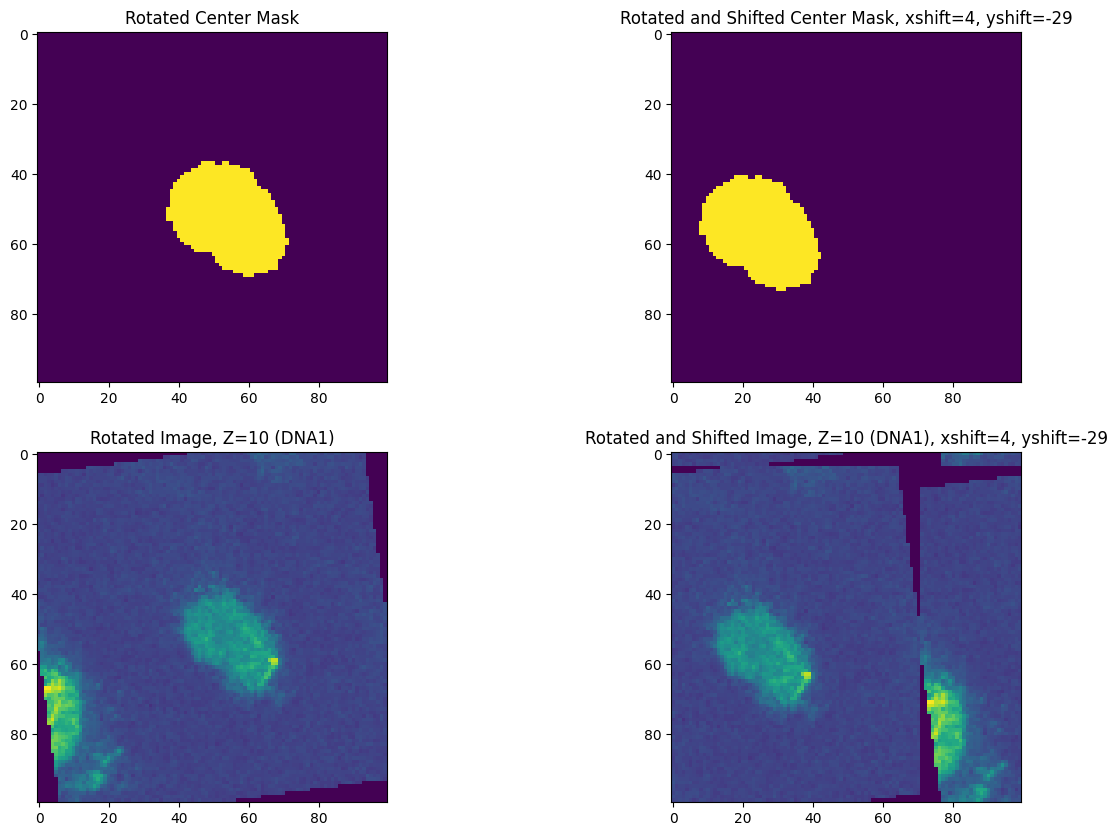

In [99]:
xshift_min, xshift_max, yshift_min, yshift_max = _get_min_max_axis(image_copy[62])

xshift = randint(xshift_min, xshift_max)
yshift = randint(yshift_min, yshift_max)

image_copy_shifted = torch.roll(image_copy, shifts=(xshift, yshift), dims=(1, 2))

# plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].imshow(image_copy[62])
axs[0, 0].set_title("Rotated Center Mask")
axs[0, 1].imshow(image_copy_shifted[62])
axs[0, 1].set_title(f"Rotated and Shifted Center Mask, xshift={xshift}, yshift={yshift}")
axs[1, 0].imshow(image_copy[10])
axs[1, 0].set_title("Rotated Image, Z=10 (DNA1)")
axs[1, 1].imshow(image_copy_shifted[10])
axs[1, 1].set_title(f"Rotated and Shifted Image, Z=10 (DNA1), xshift={xshift}, yshift={yshift}")

plt.show()
image_copy = image_copy_shifted

Now, the image passed to the model should ideally not have the artifacts of the rotation (the zero pixels). We can solve this in one of two ways:
1. Apply the nucleus (or combined) mask so that everything outside of the cell becomes zero, or
2. Fill all the zero pixels with pixel values randomly sampled from the area outside the combined mask of the original image. 

Starting with option 1:

Text(0.5, 1.0, 'Cell 0001 Z=10 (DNA1), Rotated, Shifted, and Masked')

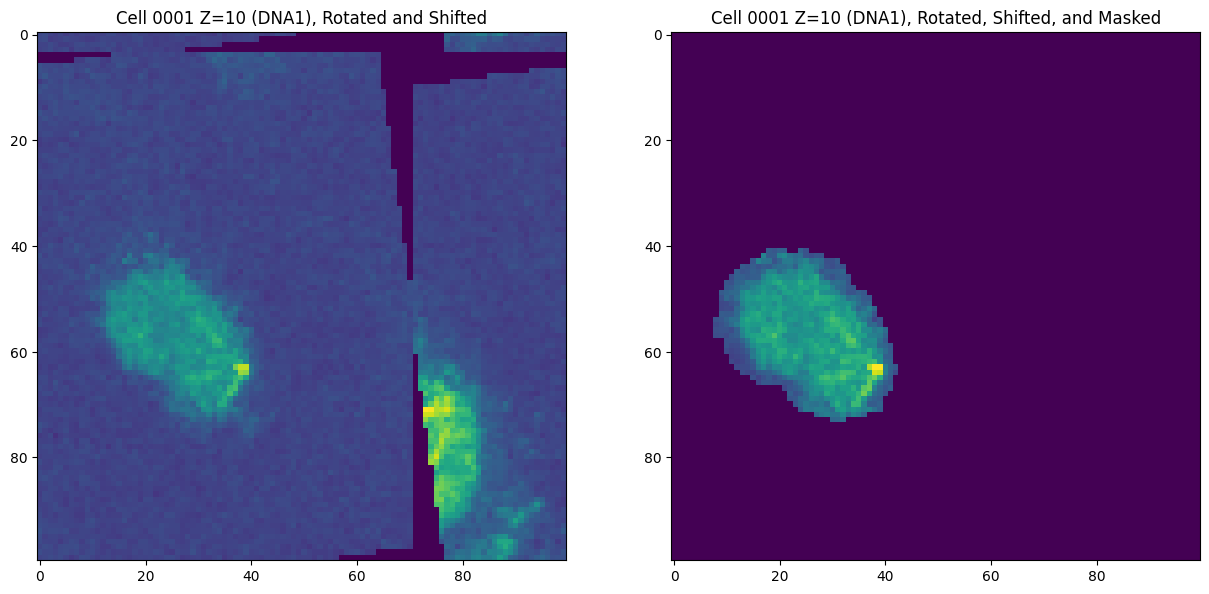

In [100]:
image_copy_masked = image_copy * image_copy[62]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image_copy[10])
axs[0].set_title("Cell 0001 Z=10 (DNA1), Rotated and Shifted")
axs[1].imshow(image_copy_masked[10])
axs[1].set_title("Cell 0001 Z=10 (DNA1), Rotated, Shifted, and Masked")

Or we can do option 2, the augmented image again shown first below:

Text(0.5, 1.0, 'Cell 0001 Z=10 (DNA1), Rotated and Shifted')

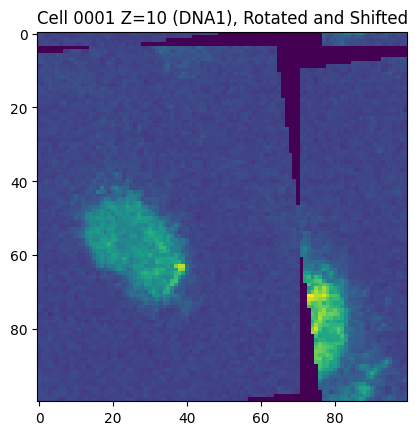

In [101]:
plt.imshow(image_copy[10])
plt.title("Cell 0001 Z=10 (DNA1), Rotated and Shifted")

In order to fill the zero pixels with appropriate noise, we need to ensure that we are not sampling this noise from any of the nuclei in the image nor any of the zero pixel values. We can simplify this by applying the combined, non-centered, mask onto our image and then sampling from all the non-zero pixels:

In [102]:
image_filled = torch.clone(image_copy)

# Apply a reversed mask to the image
sample_from = torch.clone(image_copy)
mask = ~image_copy[59].bool() # invert the mask
sample_from = sample_from * mask

# get all the non-zero sample values for each channel
sample_vals = [sample_from[z][sample_from[z] != 0].flatten() for z in range(sample_from.shape[0])]

zero_indices = (image_copy == 0)

# loop over everything except for the boolean masks
for z in range(image_copy.shape[0] - 6):
    zero_idx = torch.nonzero(zero_indices[z], as_tuple=True)
    random_vals = sample_vals[z][torch.randint(0, sample_vals[z].size(0), (zero_idx[0].numel(), ))]
    
    image_filled[z][zero_idx] = random_vals


Now, we can see that the zero values have been filled:

Text(0.5, 1.0, 'Cell 0001 Z=10 (DNA1), Rotated, Shifted, and Filled')

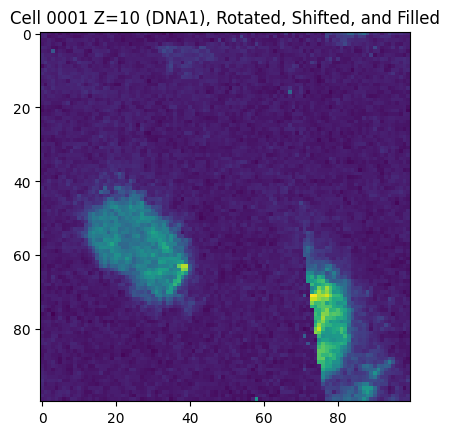

In [103]:
plt.imshow(image_filled[10])
plt.title("Cell 0001 Z=10 (DNA1), Rotated, Shifted, and Filled")

It's also possible that we would want to fill in the cells that are not of interest with random noise. We can do this simply by masking out those cells using the original mask:

We can see the DNA image and the cell masks below:

Text(0.5, 1.0, 'All Masks')

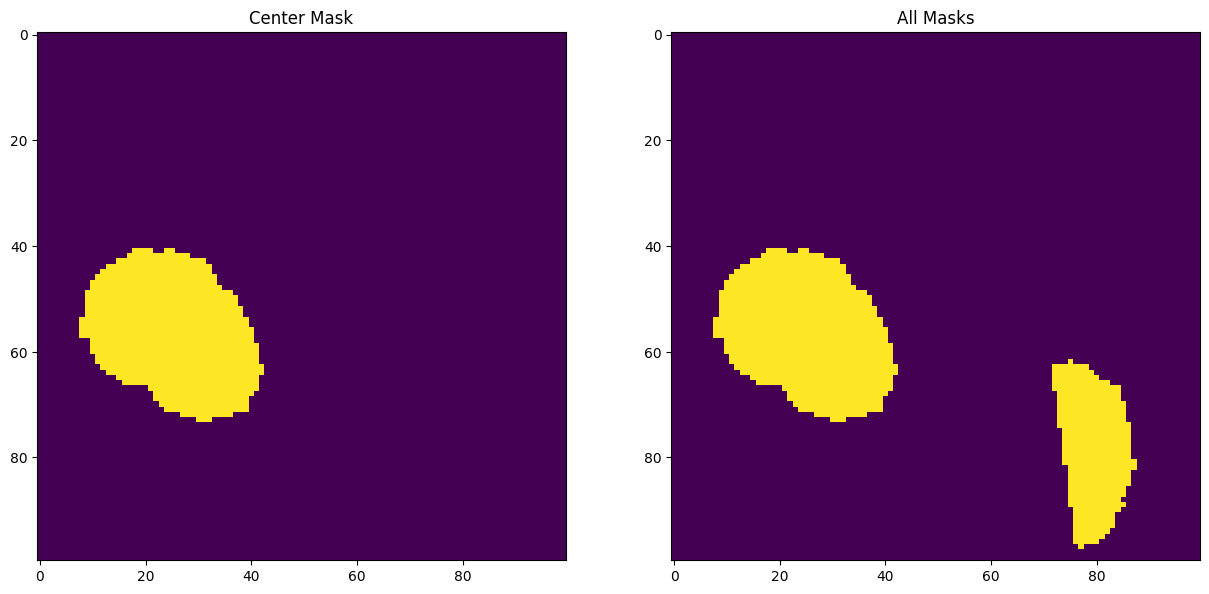

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image_copy[62])
axs[0].set_title("Center Mask")
axs[1].imshow(image_copy[59])
axs[1].set_title("All Masks")

We can use logical_not to get the mask for the other cell:

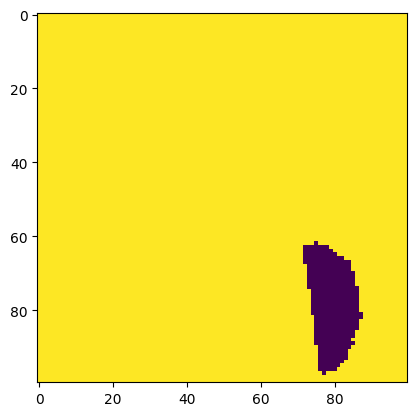

In [123]:
cells_to_exclude = ~(image_copy[59] != image_copy[62])
plt.imshow(cells_to_exclude)

Now we can apply this mask and repeat the process above to fill in the values:

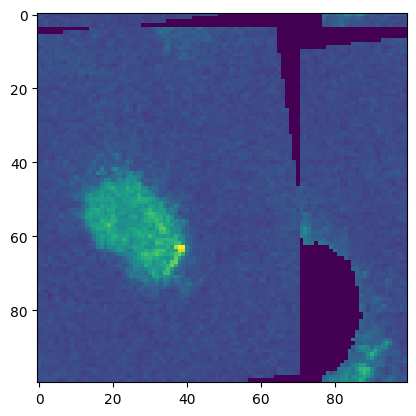

In [124]:
image_cell_filled = torch.clone(image_copy)
image_cell_filled = image_cell_filled * cells_to_exclude

plt.imshow(image_cell_filled[10])

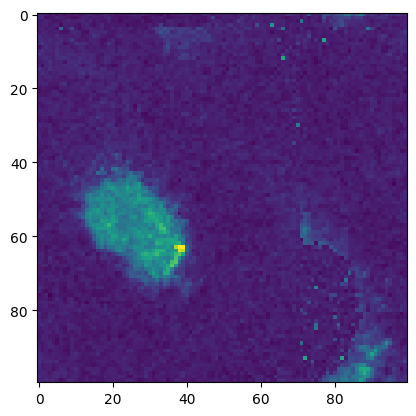

In [125]:
# Apply a reversed mask to the image
sample_from = torch.clone(image_copy)
mask = ~image_copy[59].bool() # invert the mask
sample_from = sample_from * mask

# get all the non-zero sample values for each channel
sample_vals = [sample_from[z][sample_from[z] != 0].flatten() for z in range(sample_from.shape[0])]

zero_indices = (image_cell_filled == 0)

# loop over everything except for the boolean masks
for z in range(image_copy.shape[0] - 6):
    zero_idx = torch.nonzero(zero_indices[z], as_tuple=True)
    random_vals = sample_vals[z][torch.randint(0, sample_vals[z].size(0), (zero_idx[0].numel(), ))]
    
    image_cell_filled[z][zero_idx] = random_vals
    
plt.imshow(image_cell_filled[10])

Lastly, we can use this logic to fill in random noise for the entire region around a masked cell:

Masked cell:

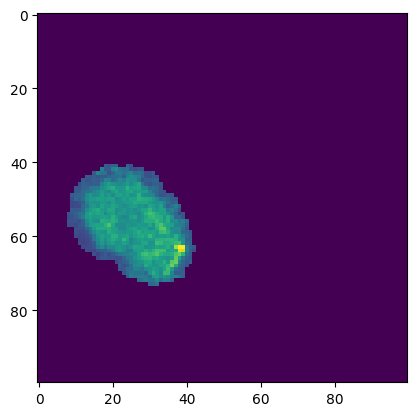

In [127]:
plt.imshow(image_copy_masked[10])

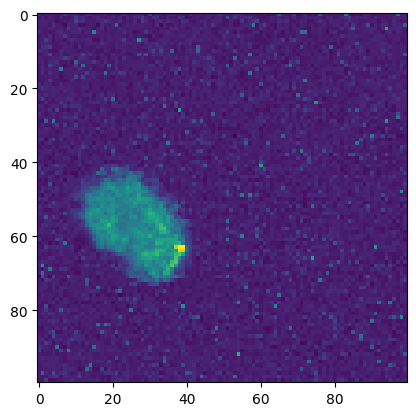

In [128]:
# Apply a reversed mask to the image
sample_from = torch.clone(image_copy)
mask = ~image_copy[59].bool() # invert the mask
sample_from = sample_from * mask

# get all the non-zero sample values for each channel
sample_vals = [sample_from[z][sample_from[z] != 0].flatten() for z in range(sample_from.shape[0])]

zero_indices = (image_copy_masked == 0)

# loop over everything except for the boolean masks
for z in range(image_copy.shape[0] - 6):
    zero_idx = torch.nonzero(zero_indices[z], as_tuple=True)
    random_vals = sample_vals[z][torch.randint(0, sample_vals[z].size(0), (zero_idx[0].numel(), ))]
    
    image_copy_masked[z][zero_idx] = random_vals
    
plt.imshow(image_copy_masked[10])